In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import yaml

## Make lists of possible tiles

- Open granule lists - filter on daylight and valid > threshold (0.25) 
- nc files contain valid flag for each pixel  
- sliding window through each granule (offset = ?) 
    - Is central pixel valid?
    - If yes, does whole tile have at least 90% (?) valid pixels?
    - If yes, save tile location in yaml (per granule)

Tile sizes:  
- 128 km = 16384 pixels
- 64 km = 4096 pixels

In [2]:
# Save directory on Sense group workspace
save_dir = "/gws/nopw/j04/sensecdt/users/flojo/data/"

# Working folder
folder = "2021_test"
filepath = Path(save_dir+folder)

month = 1
satellite = 'aqua'

meta_filepath = filepath / str(month) / satellite / "meta"
granule_folder = filepath / str(month) / satellite / "granule_data"

In [3]:
with open(meta_filepath / "scene_ids.yaml", "r") as f:
    scene_ids = yaml.safe_load(f)

In [4]:
threshold = 0.25

# filter on day/night flag and valid pixels
filtered_scene_ids = {key:val for key, val in scene_ids.items() 
                        if val["day_night_flag"] == "DAY"
                        and val["valid_pixel_fraction"] > threshold}

In [190]:
filtered_scene_ids

{'MYD021KM.A2021001.1400': {'day_night_flag': 'DAY',
  'filepaths': {'data': '/neodc/modis/data/MYD021KM/collection61/2021/01/01/MYD021KM.A2021001.1400.061.2021002162349.hdf',
   'geolocation': '/neodc/modis/data/MYD03/collection61/2021/01/01/MYD03.A2021001.1400.061.2021002162018.hdf',
   'seaice': '/badc/ecmwf-era5/data/oper/an_sfc/2021/01/01/ecmwf-era5_oper_an_sfc_202101011400.ci.nc'},
  'regions': {'barents_fraction': 0.0,
   'gin_fraction': 0.0,
   'labrador_fraction': 0.59},
  'valid_pixel_fraction': 0.59},
 'MYD021KM.A2021001.1540': {'day_night_flag': 'DAY',
  'filepaths': {'data': '/neodc/modis/data/MYD021KM/collection61/2021/01/01/MYD021KM.A2021001.1540.061.2021002162404.hdf',
   'geolocation': '/neodc/modis/data/MYD03/collection61/2021/01/01/MYD03.A2021001.1540.061.2021002161819.hdf',
   'seaice': '/badc/ecmwf-era5/data/oper/an_sfc/2021/01/01/ecmwf-era5_oper_an_sfc_202101011500.ci.nc'},
  'regions': {'barents_fraction': 0.0,
   'gin_fraction': 0.0,
   'labrador_fraction': 0.81

In [5]:
len(filtered_scene_ids)

76

In [6]:
granule = list(filtered_scene_ids.keys())[0]
granule

'MYD021KM.A2021001.1400'

In [8]:
ds = xr.open_dataset(granule_folder / f"{granule}.nc", engine = "h5netcdf")

In [9]:
ds

<xarray.Dataset> Size: 10MB
Dimensions:       (y: 2030, x: 512)
Coordinates:
    longitude     (y, x) float32 4MB ...
    latitude      (y, x) float32 4MB ...
Dimensions without coordinates: y, x
Data variables:
    study_region  (y, x) int8 1MB ...
    valid_pixel   (y, x) bool 1MB ...
Attributes:
    history:      Created by pytroll/satpy on 2025-01-09 13:30:39.462496
    Conventions:  CF-1.7

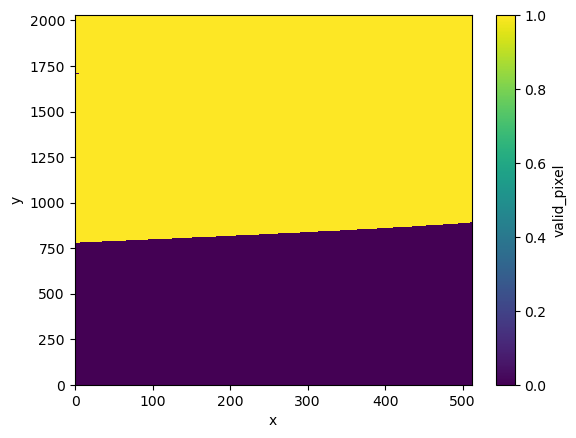

In [166]:
ds["valid_pixel"].plot()

In [ ]:
# need to define: size of tile, offset between tiles (stride)
# size of tile will determine position of first central pixel
# calculate max no. of tiles in x and y direction
# calculate position of central pixel in each tile
# for each possible tile, check valid and if so add to list of tiles
# how many possibilities do we need for sampling anchor and neighbour?
# need some kind of identifier for each valid tile within a granule? 
# But not tile_id as that would confuse things later
# poss use an i and j of tiles, grid should be the same for each slice, 
# then easy to relate anchors and neighbours
# so could simply make a list of valid (i,j) pairs for each granule

In [185]:
x_max = ds.sizes["x"]
y_max = ds.sizes["y"]

#x_max = 7
tile_size = 128
stride = 0.5

In [186]:
x = np.arange(tile_size/2-1, x_max-tile_size/2, tile_size*stride)
y = np.arange(tile_size/2-1, y_max-tile_size/2, tile_size*stride)

In [187]:
# max no. of tiles
len(x)*len(y)

210

In [151]:
x, y = np.meshgrid(x, y)

In [168]:
x.shape

(62, 15)

In [155]:
ds['valid_pixel']

<xarray.DataArray 'valid_pixel' (y: 2030, x: 512)> Size: 1MB
[1039360 values with dtype=bool]
Coordinates:
    longitude  (y, x) float32 4MB ...
    latitude   (y, x) float32 4MB ...
Dimensions without coordinates: y, x

In [169]:
# tile [0,0]
x_c = int(x[60,10])
y_c = int(y[60,10])

#ds["valid_pixel"][y_c, x_c].values
ds["valid_pixel"].isel(x=slice(x_c-tile_size//2+1, x_c+tile_size//2), 
                       y=slice(y_c-tile_size//2+1, y_c+tile_size//2)).values.mean()


np.float64(1.0)

In [176]:
x.shape

(62, 15)

In [181]:
tiles = []

for i in range(len(x)):
    for j in range(len(y)):
        x_c = int(x[i])
        y_c = int(y[j])
        tiles.append(ds["valid_pixel"].isel(x=slice(x_c-tile_size//2+1, x_c+tile_size//2), 
                                  y=slice(y_c-tile_size//2+1, y_c+tile_size//2)).values.mean())
        

In [184]:
tiles.count(1), tiles.count(0)

(528, 364)

In [189]:
# Count how many are >0.9
tiles = np.array(tiles)
tiles[tiles > 0.9].shape


(536,)

In [191]:
536/930

0.5763440860215053

In [170]:
x_c-tile_size//2, x_c+tile_size//2

(319, 383)

In [ ]:
valid tiles